In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('online_retail.csv')
df.head()

/tmp/ipython-input-3718501902.py:4: DtypeWarning: Columns (0,1,2,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('online_retail.csv')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
df = df.dropna(subset=['CustomerID'])

In [12]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [16]:
today = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
})

In [17]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12431.0,1,1,358.25
12583.0,1,1,855.86
12791.0,1,1,192.60
12838.0,1,1,390.79
13047.0,1,3,366.63


In [21]:
# Recency Score (lower recency = better)
rfm['R_score'] = pd.cut(rfm['Recency'],
                        bins=4,
                        labels=[4,3,2,1])

# Frequency Score (higher frequency = better)
rfm['F_score'] = pd.cut(rfm['Frequency'].rank(method='first'),
                        bins=4,
                        labels=[1,2,3,4])

# Monetary Score (higher money = better)
rfm['M_score'] = pd.cut(rfm['Monetary'],
                        bins=4,
                        labels=[1,2,3,4])

In [22]:
rfm['RFM_Score'] = rfm['R_score'].astype(str) + \
                   rfm['F_score'].astype(str) + \
                   rfm['M_score'].astype(str)

rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerID,,,,,,,
12431.0,1,1,358.25,3,1,1,311
12583.0,1,1,855.86,3,1,1,311
12791.0,1,1,192.60,3,1,1,311
12838.0,1,1,390.79,3,1,1,311
13047.0,1,3,366.63,3,4,1,341


In [25]:
rfm['R_score'] = pd.qcut(
    rfm['Recency'].rank(method='first'),
    4,
    labels=[4,3,2,1]
)

rfm['F_score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    4,
    labels=[1,2,3,4]
)

rfm['M_score'] = pd.qcut(
    rfm['Monetary'].rank(method='first'),
    4,
    labels=[1,2,3,4]
)

In [26]:
rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerID,,,,,,,
12431.0,1,1,358.25,4,1,3,413
12583.0,1,1,855.86,4,1,4,414
12791.0,1,1,192.60,4,1,1,411
12838.0,1,1,390.79,4,1,3,413
13047.0,1,3,366.63,4,4,3,443


In [27]:
def segment_customer(row):

    if row['R_score'] == 4 and row['F_score'] == 4 and row['M_score'] == 4:
        return 'Champions'

    elif row['F_score'] >= 3 and row['M_score'] >= 3:
        return 'Loyal Customers'

    elif row['R_score'] <= 2 and row['F_score'] >= 3:
        return 'At Risk'

    elif row['R_score'] == 4 and row['F_score'] == 1:
        return 'New Customers'

    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,
12431.0,1,1,358.25,4,1,3,413,New Customers
12583.0,1,1,855.86,4,1,4,414,New Customers
12791.0,1,1,192.60,4,1,1,411,New Customers
12838.0,1,1,390.79,4,1,3,413,New Customers
13047.0,1,3,366.63,4,4,3,443,Loyal Customers


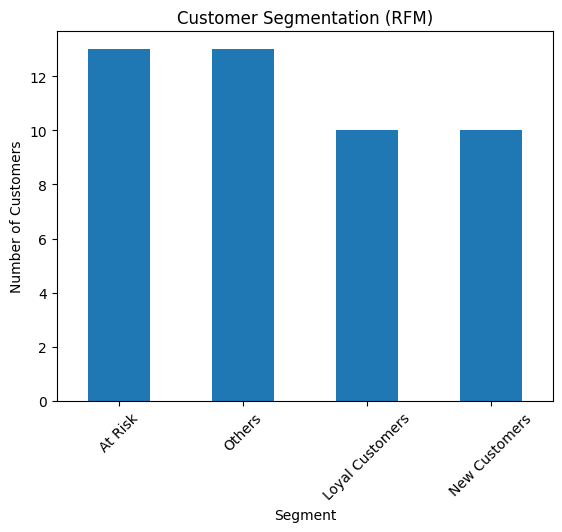

In [28]:
rfm['Segment'].value_counts()
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().plot(kind='bar')

plt.title('Customer Segmentation (RFM)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()
rfm.to_csv('rfm_segments.csv')